In [1]:
from keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 300
WIDTH = 300

base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(HEIGHT, WIDTH, 3))

base_model.summary()

Using TensorFlow backend.
W0927 21:15:02.702971 16432 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 21:15:02.726971 16432 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 21:15:02.735990 16432 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0927 21:15:02.758972 16432 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [2]:
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = r"D:\NUS_TERM2_CA2\Train"
TEST_DIR = r"D:\NUS_TERM2_CA2\Validation"

HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255)

datagen2 = ImageDataGenerator(
    rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

validation_generator = datagen2.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)


Found 2424 images belonging to 3 classes.
Found 720 images belonging to 3 classes.


In [3]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = ["food", "landmark", "people"]
FC_LAYERS = [128, 128]
dropout = 0.3

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

finetune_model.summary()

W0927 21:15:27.072768 16432 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\backend\tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [4]:
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from PIL import Image

NUM_EPOCHS = 50
BATCH_SIZE = 64
num_train_images = 2424
num_test_images = 720


finetune_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(generator=train_generator, 
                                       validation_data=validation_generator,
                                       epochs=NUM_EPOCHS, 
                                       workers=12, 
                                       validation_steps=num_test_images // BATCH_SIZE,
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, 
                                       callbacks=callbacks_list)

W0927 21:19:12.284033 16432 deprecation_wrapper.py:119] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0927 21:19:12.354032 16432 deprecation.py:323] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
37/37 [==============================] - 49s 1s/step - loss: 1.3299 - acc: 0.4932 - val_loss: 1.7167 - val_acc: 0.3068

Epoch 00001: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 2/50
37/37 [==============================] - 18s 482ms/step - loss: 0.5916 - acc: 0.7534 - val_loss: 1.9050 - val_acc: 0.3182

Epoch 00002: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 3/50
37/37 [==============================] - 35s 957ms/step - loss: 0.3300 - acc: 0.8919 - val_loss: 2.3281 - val_acc: 0.2727

Epoch 00003: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 4/50
37/37 [==============================] - 33s 896ms/step - loss: 0.4805 - acc: 0.8108 - val_loss: 2.0015 - val_acc: 0.3864

Epoch 00004: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 5/50
37/37 [==============================] - 34s 931ms/step - loss: 0.3358 - acc: 0.8851 - val_loss: 2.7557 - val_acc: 0.2500

Epoch 00005: saving model to ./checkpoints/ResNet50_model

37/37 [==============================] - 7s 181ms/step - loss: 0.1669 - acc: 0.9493 - val_loss: 3.8612 - val_acc: 0.2955

Epoch 00041: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 42/50
37/37 [==============================] - 5s 139ms/step - loss: 0.1878 - acc: 0.9561 - val_loss: 3.8625 - val_acc: 0.2500

Epoch 00042: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 43/50
37/37 [==============================] - 5s 141ms/step - loss: 0.0799 - acc: 0.9730 - val_loss: 4.2891 - val_acc: 0.2614

Epoch 00043: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 44/50
37/37 [==============================] - 5s 143ms/step - loss: 0.1510 - acc: 0.9595 - val_loss: 4.3524 - val_acc: 0.2955

Epoch 00044: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 45/50
37/37 [==============================] - 6s 151ms/step - loss: 0.1900 - acc: 0.9324 - val_loss: 4.4916 - val_acc: 0.2614

Epoch 00045: saving model to ./checkpoints/ResNet50_model_weights.

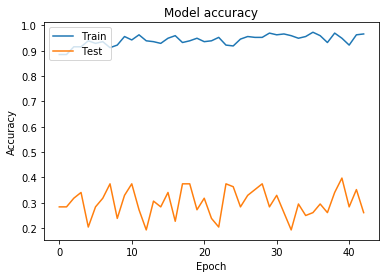

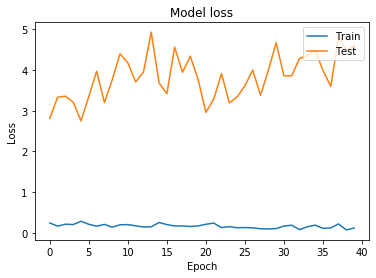

In [6]:
import matplotlib.pyplot as plt
# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
plt.plot(history.history['acc'][7:])
plt.plot(history.history['val_acc'][7:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


Y_pred = finetune_model.predict_generator(validation_generator, num_test_images//8, workers=12, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = class_list #= ["food", "landmark", "people"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

90/90 [==============================] - 12s 133ms/step
Confusion Matrix
[[  0 293   0]
 [  0 218   0]
 [  0 209   0]]
Classification Report
              precision    recall  f1-score   support

        food       0.00      0.00      0.00       293
    landmark       0.30      1.00      0.46       218
      people       0.00      0.00      0.00       209

    accuracy                           0.30       720
   macro avg       0.10      0.33      0.15       720
weighted avg       0.09      0.30      0.14       720



c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
TEST_DIR = r"D:\NUS_TERM2_CA2\Validation"

test_generator = datagen.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

# Todo, add test
filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = finetune_model.evaluate_generator(test_generator, workers=8, steps = nb_samples //BATCH_SIZE, verbose=1)
print('Loss is')
print(loss)
print('accuracy is')
print(acc)

Found 720 images belonging to 3 classes.
11/11 [==============================] - 16s 1s/step
Loss is
4.326916369524869
accuracy is
0.3053977272727273


In [ ]:
predict = finetune_model.predict_generator(test_generator,steps = nb_samples //BATCH_SIZE, verbose=1)
